In [21]:
import os
import json
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pycountry

# set the font family and style for plots
plt.rcParams['font.sans-serif']=['Arial']
plt.style.use('fivethirtyeight')

In [22]:
path = "./datasets"
files = os.listdir(path)
# store articles' abstracts
abstract_dict = {}
# store all months of all involved date
month_count = {}
# counter for all keywords of articles
keyword_dict = {}
# counter for all keywords of articles group by months
keyword_count_date = {}
# counter for all countries involved in articles group by months
abs_word_month_counter = {}
# to calculate the relationship weight of keywords
person_keywords_relation = {}
# store articles' keywords
keywords_each_ariticle = []
# store articles' core sentence
core_list = []

In [23]:
import nltk
from nameparser.parser import HumanName

# recognize human name in text
def get_human_names(text):
    tokens = nltk.tokenize.word_tokenize(text)
    pos = nltk.pos_tag(tokens)
    sentt = nltk.ne_chunk(pos, binary = False)
    person_list = []
    person = []
    name = ""
    for subtree in sentt.subtrees(filter=lambda t: t.label() == 'PERSON'):
        for leaf in subtree.leaves():
            person.append(leaf[0])
        if len(person) > 1:
            for part in person:
                name += part + ' '
            if name[:-1] not in person_list:
                person_list.append(name[:-1])
            name = ''
        person = []

    return (person_list)


In [24]:
for fname in files:
    if fname.startswith('data_slice'):
        # read data from directory
        data = open('./datasets/' + fname).read()
        doc_list = json.loads(data)
        for doc in doc_list:
            date = doc['date']
            persons = doc['persons']
            core = doc['core']
            keywords = doc['keywords']
            abstract = doc['abstract']
            # rebuild date string
            month = date.split('T')[0].split('-')[0] + '-' +  date.split('T')[0].split('-')[1]

            # remove the duplicates
            overlaped = True
            if abstract not in abstract_dict:
                abstract_dict[abstract] = 1
                overlaped = False

            related = False
            for word in keywords:
                # confirm the article is related to 2019-nCoV
                if '2019-nCoV' in word:
                    related = True
                if word not in keyword_dict:
                    keyword_dict[word] = {}
                if month not in keyword_dict[word]:
                    keyword_dict[word][month] = 0
                keyword_dict[word][month] += 1
            
            if overlaped is False and related is True:
                if month not in month_count:
                    month_count[month] = 0
                month_count[month] += 1

                # count the mentioned number of countries group by months
                for country in pycountry.countries:
                    name = country.name
                    if name in abstract:
                        if name not in abs_word_month_counter:
                            abs_word_month_counter[name] = {}
                        if month not in abs_word_month_counter[name]:
                            abs_word_month_counter[name][month] = 0
                        abs_word_month_counter[name][month] += 1
    
                keywords_each_ariticle.append(keywords)
                core_list.append(core)


In [25]:
# show the change of mentioned number of selected country
def show_trend(x):
    sorted_months = list(abs_word_month_counter[x].keys())
    sorted_months.sort()
    month_count_list = []

    for month in abs_word_month_counter[x]:
        month_count_list.append(abs_word_month_counter[x][month])

    fig, ax = plt.subplots(figsize=(6,4))
    plt.rcParams.update({'font.size': 6})
    bar = plt.bar(sorted_months, month_count_list, align='center', alpha=0.5)
    plt.xticks(rotation=-45)
    plt.title('Mentioned Number of ' + x)
    plt.xlabel('Date')
    plt.ylabel('Number')
    

# filter the keywords which contain country name and having high weight
candidates = []
for word in abs_word_month_counter:
    sum = 0
    for month in abs_word_month_counter[word]:
        sum += abs_word_month_counter[word][month]
    for country in pycountry.countries:
        if country.name in word and sum > 50:
            if not (word.startswith('United') and len(word) > 15):
                if not word.startswith('Communitist'):
                    candidates.append(word)

interact(show_trend, x=candidates)

interactive(children=(Dropdown(description='x', options=('Germany', 'United States', 'Jersey', 'Georgia', 'Chi…

<function __main__.show_trend(x)>

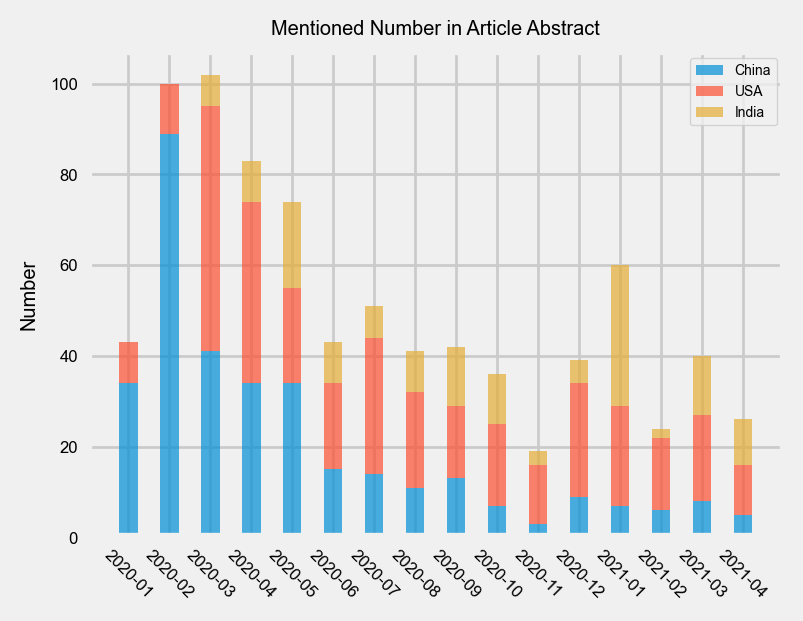

In [26]:
months = list(month_count.keys())
months.sort()
china_mcount_bymonth = []
usa_mcount_bymonth = []
india_mcount_bymonth = []

# compute the mentioned times of selected three country (China, US, and India)
for month in months:
    if month in abs_word_month_counter['China']:
        china_mcount_bymonth.append(abs_word_month_counter['China'][month])
    else:
        china_mcount_bymonth.append(0)
    if month in abs_word_month_counter['United States']:
        usa_mcount_bymonth.append(abs_word_month_counter['United States'][month])
    else:
        usa_mcount_bymonth.append(0)
    if month in abs_word_month_counter['India']:
        india_mcount_bymonth.append(abs_word_month_counter['India'][month])
    else:
        india_mcount_bymonth.append(0)
    
width = 0.45       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
plt.rcParams.update({'font.size': 5})
ax.bar(months, china_mcount_bymonth, width, label='China', alpha=0.7)
ax.bar(months, usa_mcount_bymonth, width, bottom=china_mcount_bymonth, label='USA', alpha=0.7)

# get the bottom count for India
sum_list = []
for (item1, item2) in zip(china_mcount_bymonth, usa_mcount_bymonth):
    sum_list.append(item1+item2)

ax.bar(months, india_mcount_bymonth, width, bottom=sum_list, label='India', alpha=0.7)

ax.set_ylabel('Number')
ax.set_title('Mentioned Number in Article Abstract')
plt.xticks(rotation=-45)
ax.legend()

In [27]:
import networkx as nx  
import matplotlib.pyplot as plt 
word_counter = {}
network_dict = {}
country_dict = {}

for country in pycountry.countries:
    country_dict[country.name] = 1

# build a graph with networkx
G = nx.Graph() 

# build relationship between keywords
for words in keywords_each_ariticle:
    for Iword in words:
        Iword = Iword.split('(')[0]
        if Iword not in word_counter:
            word_counter[Iword] = 0
        word_counter[Iword] += 1
        for Jword in words:
            Jword = Jword.split('(')[0]
            if Iword not in network_dict:
                network_dict[Iword] = {}
            if Jword not in network_dict[Iword]:
                network_dict[Iword][Jword] = 0
            network_dict[Iword][Jword] += 1

# add edge to the graph
for source in network_dict:
    for target in network_dict[source]:
        if source != target and source in country_dict:
            if network_dict[source][target] > 50:
                _source = source
                _target = target
                #if source != 'Coronavirus' and target != 'Coronavirus':
                G.add_edge(_source, _target, weight = network_dict[source][target])



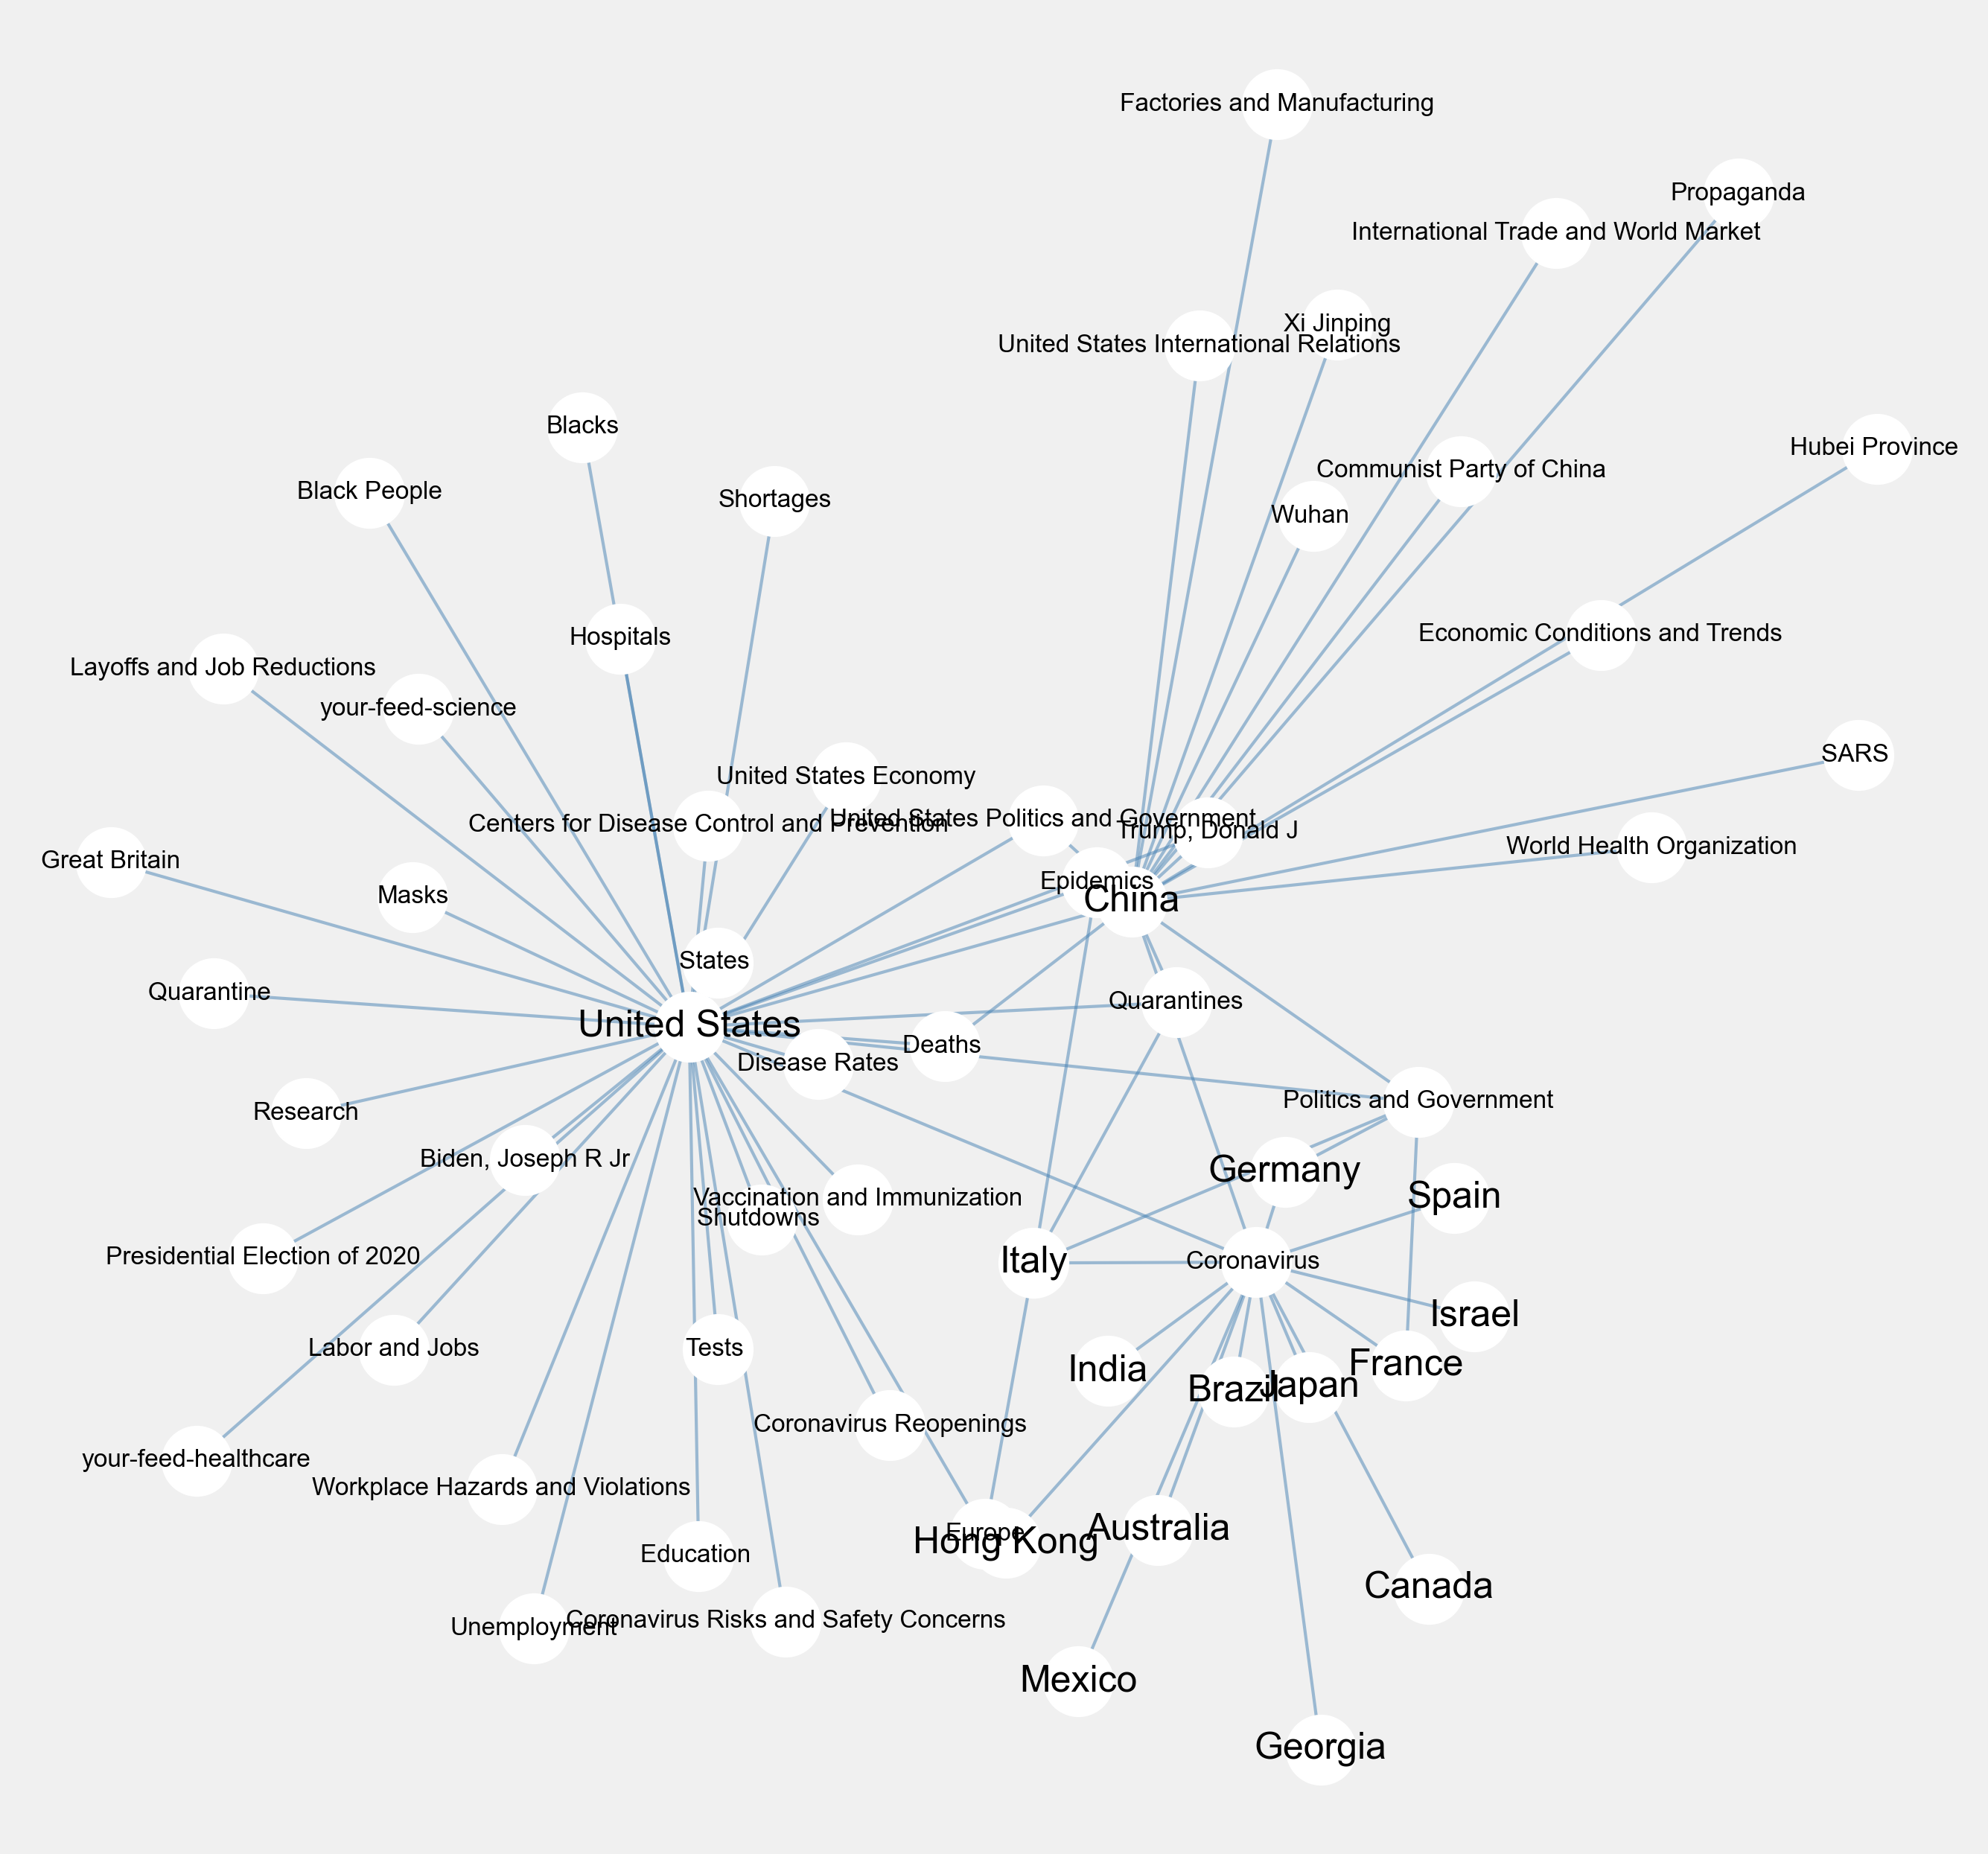

In [28]:
from matplotlib.pyplot import figure, text

# add edge to the graph
word_counter_values = list(word_counter.values())
max_word_counter = float(max(word_counter_values))
for word in word_counter:
    if word in country_dict:
        word_counter[word] = 12
    else:
        word_counter[word] = 8
word_counter_values = [j/max_word_counter for j in word_counter_values]

fig, ax = plt.subplots(figsize=(10,10),dpi=300)
plt.rcParams.update({'font.size': 4})
plt.grid(False)
# compute the positions for all nodes
pos=nx.spring_layout(G, iterations=5000, threshold=0.005)
# draw all the nodes
nodes = nx.draw_networkx_nodes(G, pos, node_color="white", alpha = 1, node_size = 500)

# draw the labels
for node, (x, y) in pos.items():
    if node == 'United':
        node = 'USA'
    text(x, y, node, fontsize=word_counter[node], ha='center', va='center')

# draw the edges
edges = nx.draw_networkx_edges(G, pos, alpha = 0.5, edge_color='steelblue', width=1)

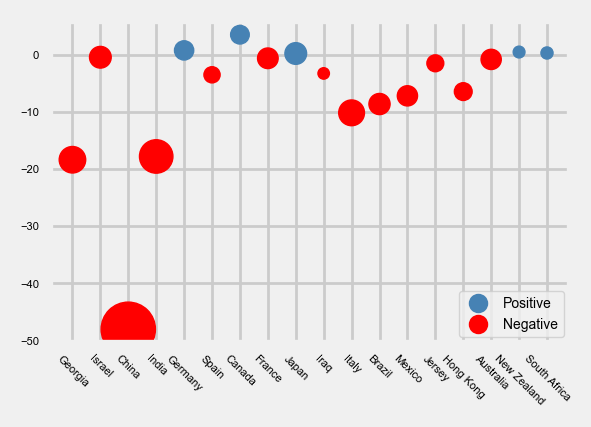

In [29]:
from nltk.sentiment import SentimentIntensityAnalyzer
from matplotlib.lines import Line2D

# initialize a sentiment analyzer
sia = SentimentIntensityAnalyzer()
country_sentiment = dict()

index = 0

# compute sentiment polarity score for each article
for core in core_list:
    score = sia.polarity_scores(core)
    
    for country in country_dict:
        if country in core:
            if country not in country_sentiment:
                country_sentiment[country] = {}
                country_sentiment[country]['score'] = 0
                country_sentiment[country]['counter'] = 0
            country_sentiment[country]['score'] += score['compound']
            country_sentiment[country]['counter'] += 1

countries = [] 
for country in country_sentiment:
    if country_sentiment[country]['counter'] > 15:
        countries.append(country)

scores = []
for country in countries:
    scores.append(country_sentiment[country]['score'])

counts = []
for country in countries:
    counts.append(country_sentiment[country]['counter'])

labels = []
for country in countries:
    if country_sentiment[country]['score'] >= 0:
        labels.append('steelblue')
    else:
        labels.append('red')

# plot the sentiment scores for each country
fig, ax = plt.subplots(figsize=(3,2),dpi=200)
plt.rcParams.update({'font.size': 5})
plt.scatter(countries, scores, s=counts, c=labels)
plt.xticks(rotation=-45)
legend_markers = [Line2D([0], [0], marker='o', lw=0, color='steelblue', label='Positive'),
                   Line2D([0], [0], marker='o', lw=0, color='red', label='Negative')]

plt.legend(handles=legend_markers, loc='lower right')